# Fonctions utiles

In [119]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
import sklearn.svm

def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def plot_frontiere2(datax,data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid2(datax = datax,data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])

def make_grid2(datax=None,data=None,xmin=-10,xmax=10,ymin=-10,ymax=10,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(datax[:,0]),  np.min(datax[:,0]), np.max(datax[:,1]), np.min(datax[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
        xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//2)
        xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//2)
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y.reshape(-1, 1)

# Perceptron

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.utils import shuffle


def perceptron_loss(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return np.maximum(0,-y*(x@w))


def perceptron_grad(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return np.where((-y*x)*perceptron_loss(w,x,y) < 0, 0, -y*x)


def proj_poly(datax):
    datax2 = datax
    for i in range(datax.shape[1]):
        for j in range(i,datax.shape[1]):
            data = datax[:,i]*datax[:,j]
            datax2 = np.c_[datax2,data]
    return datax2


def proj_biais(datax):
    datax2 = datax
    data = np.ones((datax.shape[0]))
    datax2 = np.c_[data,datax2]
    return datax2
        

class Lineaire(object):
    def __init__(self,loss=perceptron_loss,loss_g=perceptron_grad,max_iter=100,eps=0.01,pol=False):
        self.max_iter, self.eps = max_iter,eps
        self.w = None
        self.loss,self.loss_g = loss,loss_g
        self.poly = pol
        
    def fit(self,datax,datay):
        if self.poly:
            costs = []
            datax = proj_biais(proj_poly(datax))
            self.w = np.random.randn(datax.shape[1],1)
            datay = datay.reshape(-1,1)
            w_suivi = []
        else:
            costs = []
            self.w = np.random.randn(datax.shape[1],1)
            datay = datay.reshape(-1,1)
            w_suivi = []
        for i in range(self.max_iter):
            self.w = self.w - self.eps * self.loss_g(self.w,datax,datay).mean(axis=0).reshape(-1,1)
            costs.append(self.loss(self.w,datax,datay).sum())
            w_suivi.append(self.w)
        return (costs,w_suivi)
    
    def fit_stochastique(self,datax,datay):
        costs = []
        self.w = np.random.randn(datax.shape[1],1)
        datay = datay.reshape(-1,1)
        w_suivi = []
        for i in range(self.max_iter):
            randomize = np.arange(datax.shape[0])
            np.random.shuffle(randomize)
            datax = datax[randomize]
            datay = datay[randomize]
            for j in range(datax.shape[0]):
                self.w = self.w - self.eps * self.loss_g(self.w,datax[j],datay[j]).mean(axis=0).reshape(-1,1)
            costs.append(self.loss(self.w,datax,datay).sum())
            w_suivi.append(self.w)
        return (costs,w_suivi)
    
    def fit_mini_batch(self,datax,datay,m):
        iteration = int(datax.shape[0]/m)
        costs = []
        self.w = np.random.randn(datax.shape[1],1)
        datay = datay.reshape(-1,1)
        w_suivi = []
        for i in range(self.max_iter*iteration):
            randomize = np.arange(m)
            np.random.shuffle(randomize)
            datax2 = datax[randomize]
            datay2 = datay[randomize]
            self.w = self.w - self.eps * self.loss_g(self.w,datax2,datay2).mean(axis=0).reshape(-1,1)
            costs.append(self.loss(self.w,datax,datay).sum())
            w_suivi.append(self.w)
        return (costs,w_suivi)
    

    def predict(self,datax):
        if self.poly: 
            datax = proj_poly(proj_poly(datax))
        return np.sign(datax@self.w)

    def score(self,datax,datay):
        yhat = self.predict(datax).reshape(-1)
        return (yhat==datay).mean()

def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")


# Frontière de décision, loss , temps d'execution en fonction de batch, mini batch et stochastique

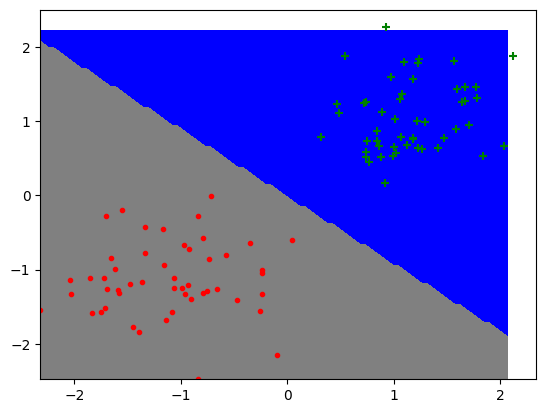

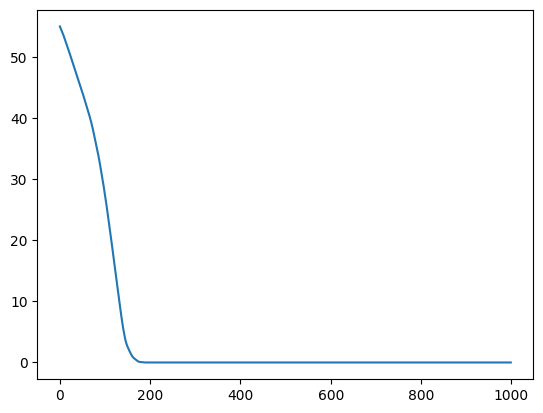

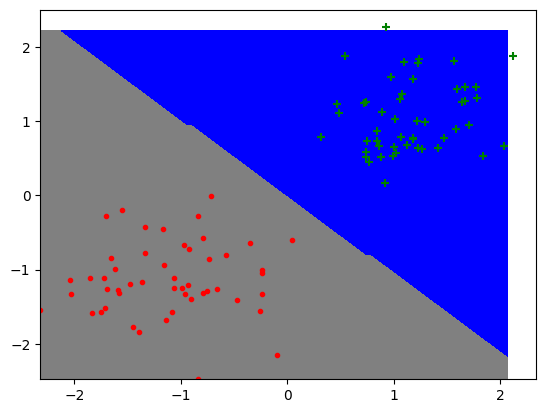

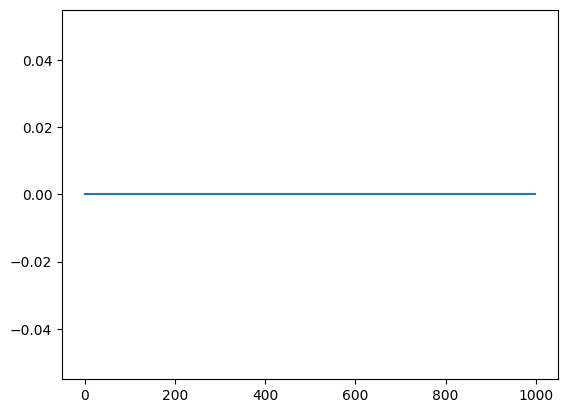

rapport temps stochastique vs batch : 56.87661470556486 fois plus de temps


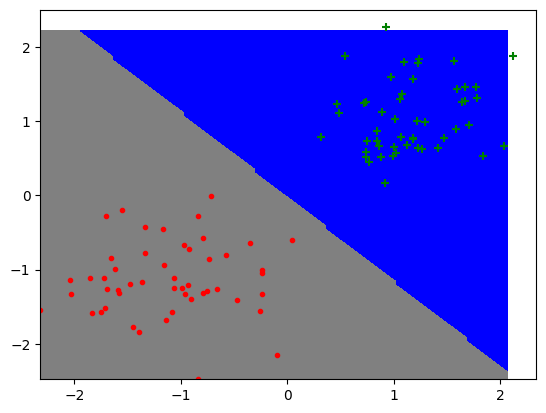

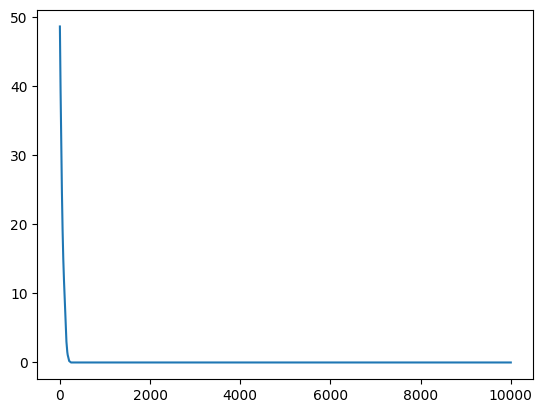

rapport temps stochastique vs batch : 56.87661470556486 fois plus de temps
rapport temps mini batch vs batch : 9.386036070253436 fois plus de temps
rapport temps stochastique vs mini_batch : 6.059705532756292 fois plus de temps


In [35]:
import time
## Tirage d'un jeu de données aléatoire avec un petit bruit
datax, datay = gen_arti(nbex=100,epsilon=0.4)
## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
grid, x_grid, y_grid = make_grid(xmin=-2, xmax=2, ymin=-2, ymax=2, step=100)
##############################################################################################################
#batch

start = time.time()
L = Lineaire(max_iter=1000)
costs = L.fit(datax,datay)
end = time.time()
elapsed = end - start

plt.figure()
## Visualisation des données et de la frontière de décision pour un vecteur de poids w
w = L.w
plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
plot_data(datax,datay)

## Visualisation de la fonction de coût en 2D
plt.figure()
plt.plot(np.arange(len(costs[0])),costs[0])

plt.show()


###########################################################################################################
#stochastique

start = time.time()
L = Lineaire(max_iter=1000)
costs = L.fit_stochastique(datax,datay)
end = time.time()
elapsed2 = end - start


plt.figure()
## Visualisation des données et de la frontière de décision pour un vecteur de poids w
w = L.w
plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
plot_data(datax,datay)

## Visualisation de la fonction de coût en 2D
plt.figure()
plt.plot(np.arange(len(costs[0])),costs[0])

plt.show()

print(f'rapport temps stochastique vs batch : {elapsed2/elapsed} fois plus de temps')


############################################################################################################
#minibatch
start = time.time()
L = Lineaire(max_iter=1000)
costs = L.fit_mini_batch(datax,datay,10)
end = time.time()
elapsed3 = end - start


plt.figure()
## Visualisation des données et de la frontière de décision pour un vecteur de poids w
w = L.w
plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
plot_data(datax,datay)

## Visualisation de la fonction de coût en 2D
plt.figure()
plt.plot(np.arange(len(costs[0])),costs[0])

plt.show()

print(f'rapport temps stochastique vs batch : {elapsed2/elapsed} fois plus de temps')
print(f'rapport temps mini batch vs batch : {elapsed3/elapsed} fois plus de temps')
print(f'rapport temps stochastique vs mini_batch : {elapsed2/elapsed3} fois plus de temps')

# Temps d'execution des différentes methodes de gradient en fonction du bruit

In [9]:
eps=0
axe =[]
elapsed=[]
elapsed2=[]
elapsed3=[]
for i in range(11):
    axe.append(i)
    eps+=0.5
    datax, datay = gen_arti(nbex=100,epsilon=eps)
    ##############################################################################################################
    #batch
    
    start = time.time()
    L = Lineaire(max_iter=1000)
    costs = L.fit(datax,datay)
    end = time.time()
    elapsed.append(end - start)


    ###########################################################################################################
    #stochastique
    
    start = time.time()
    L = Lineaire(max_iter=1000)
    costs = L.fit_stochastique(datax,datay)
    end = time.time()
    elapsed2.append(end - start)


    ############################################################################################################
    #minibatch
    
    start = time.time()
    L = Lineaire(max_iter=1000)
    costs = L.fit_mini_batch(datax,datay,10)
    end = time.time()
    elapsed3.append(end - start)



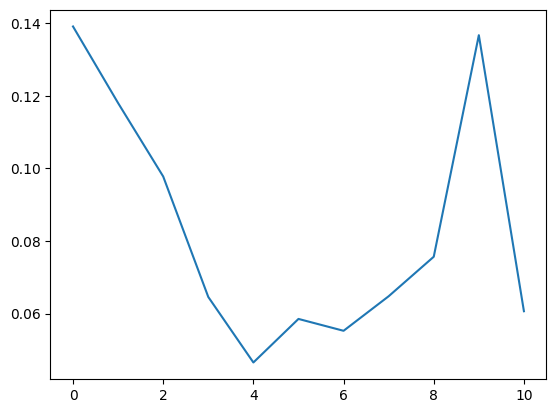

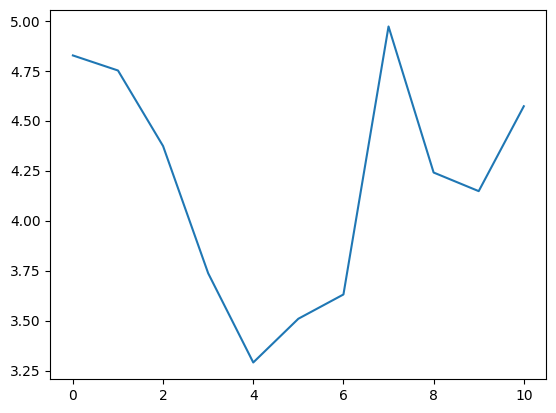

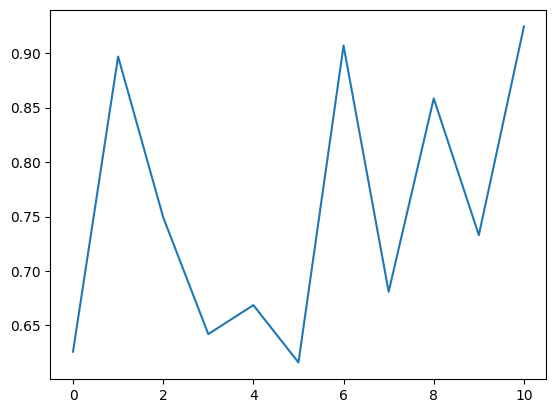

In [10]:
plt.plot(axe,elapsed, label='batch')
plt.show()
plt.plot(axe,elapsed2, label='stochastic')
plt.show()
plt.plot(axe,elapsed3,label='mini_batch')
plt.show()

# Données images

6 vs 9 :
score train = 0.5076452599388379
score test = 0.4899135446685879


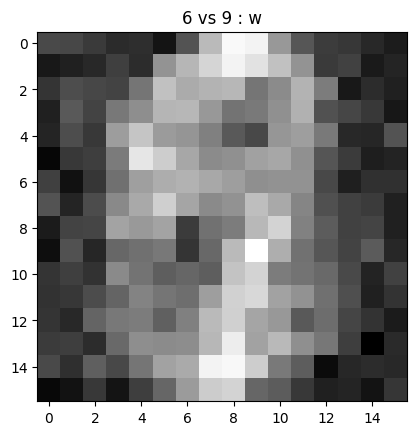

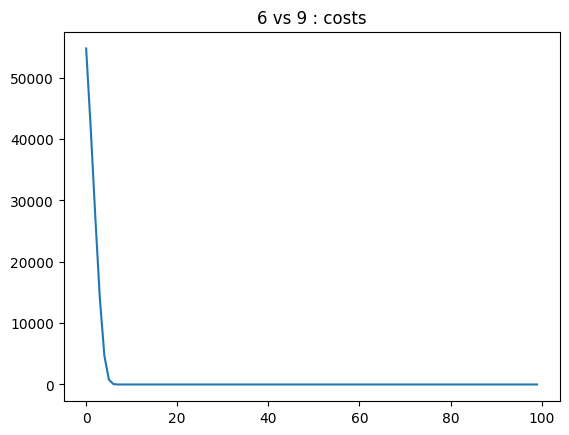

6 vs others :
score train = 0.18406254286106158
score test = 0.19382162431489786


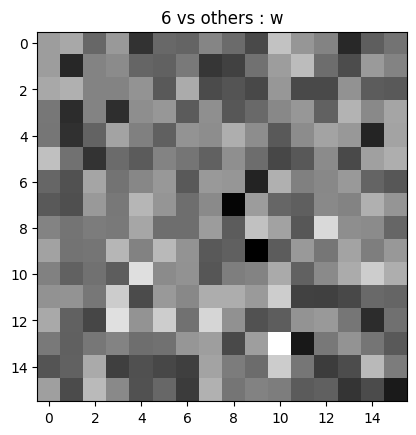

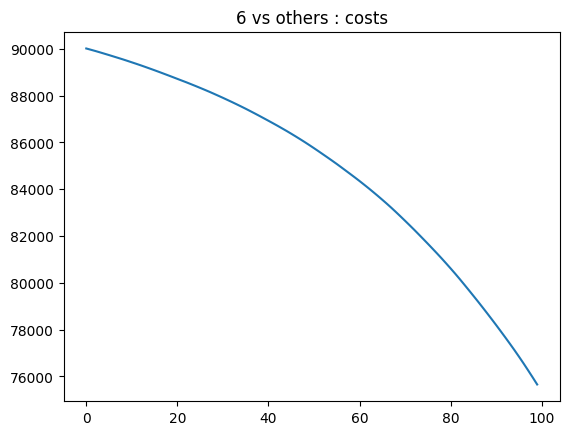

In [34]:
uspsdatatrain = "data/USPS_train.txt"
uspsdatatest = "data/USPS_test.txt"
alltrainx,alltrainy = load_usps(uspsdatatrain)
alltestx,alltesty = load_usps(uspsdatatest)

# plt.figure()
# plt.imshow(alltrainx[0].reshape(16,16))
# plt.show()

oneVSone = True
oneVSall = True

if oneVSone:
    # 6 vs 9
    pos,neg = 6,9
    datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
    testx,testy = get_usps([neg,pos],alltestx,alltesty)
    datay_sign = np.where(datay==pos,1,-1)
    testy_sign = np.where(testy==pos,1,-1)

    L = Lineaire()

    costs = L.fit(datax,datay)
    show_usps(L.w)
    plt.title(f"{pos} vs {neg} : w")

    print(f"{pos} vs {neg} :")
    print("score train =", L.score(datax,datay_sign))
    print("score test =", L.score(testx,testy_sign))

    plt.figure()
    plt.plot(costs[0])
    plt.title(f"{pos} vs {neg} : costs")

    plt.show()

if oneVSall:
    # 6 vs others
    neg = 6
    pos = [i for i in range(10) if i != neg]
    datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
    testx,testy = get_usps([neg,pos],alltestx,alltesty)
    datay_sign = np.where(datay==neg,-1,1)
    testy_sign = np.where(testy==neg,-1,1)

    L = Lineaire()

    costs = L.fit(datax,datay_sign)
    show_usps(L.w)
    plt.title(f"{neg} vs others : w")

    print(f"{neg} vs others :")
    print("score train =", L.score(datax,datay_sign))
    print("score test =", L.score(testx,testy_sign))

    plt.figure()
    plt.plot(costs[0])
    plt.title(f"{neg} vs others : costs")

    plt.show()

# Test fonction gen polynomiale et biais

In [ ]:
datax, datay = gen_arti(nbex=100,epsilon=0.4)
print(datax.shape)
data = proj_poly(datax)
print(datax.shape, data.shape)
data = proj_biais(data)
print(data.shape)

(1000, 6)
(6, 1)


<Figure size 640x480 with 0 Axes>

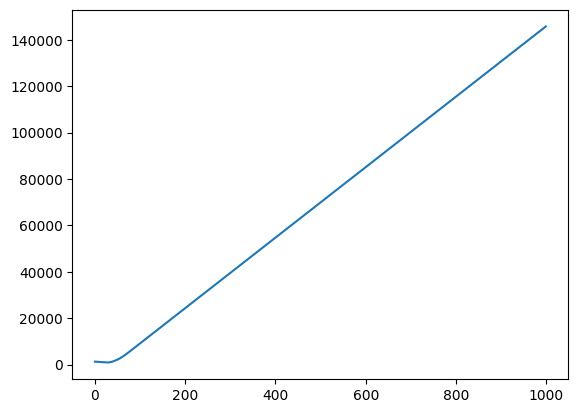

In [130]:
#batch
datax, datay = gen_arti(nbex=1000,epsilon=0.5,data_type=1)
start = time.time()
L = Lineaire(max_iter=1000,pol=True)
costs = L.fit(datax,datay)
end = time.time()
elapsed = end - start


plt.figure()
## Visualisation des données et de la frontière de décision pour un vecteur de poids w
w = L.w
data = proj_biais(proj_poly(datax))
print(data.shape)
print(w.shape)

plt.show()
## Visualisation de la fonction de coût en 2D
plt.figure()
plt.plot(np.arange(len(costs[0])),costs[0])


###### datax, datay = gen_arti(nbex=100,epsilon=0.4)
start = time.time()
L = Lineaire(max_iter=1000)
costs = L.fit(datax,datay)
end = time.time()
elapsed = end - start

datax, datay = gen_arti(nbex=100,epsilon=0.4)
print(L.predict(datax))
print(L.score(datax,datay))